### Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion
Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#To add GPU in mac use tensorflow-metal
#print("TensorFlow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.16.2
Num GPUs Available:  1


In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path("./Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset


In [6]:
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.2  # 20% of data for validation

Use 80% of the images for training, and 20% for validation.

In [7]:

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    label_mode='int'
)

# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    label_mode='int'
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-11-20 18:09:57.165823: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-20 18:09:57.165885: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-20 18:09:57.165898: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-20 18:09:57.166229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 18:09:57.166262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

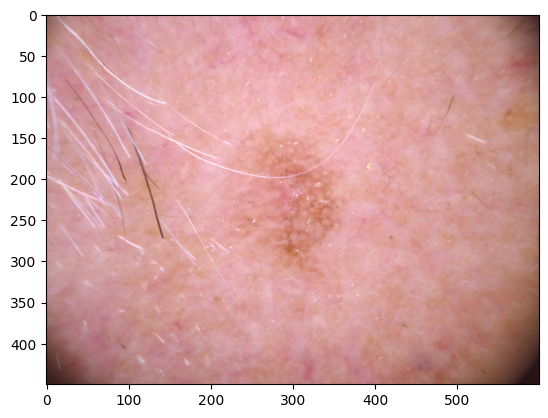

In [9]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

2024-11-20 18:14:45.271943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


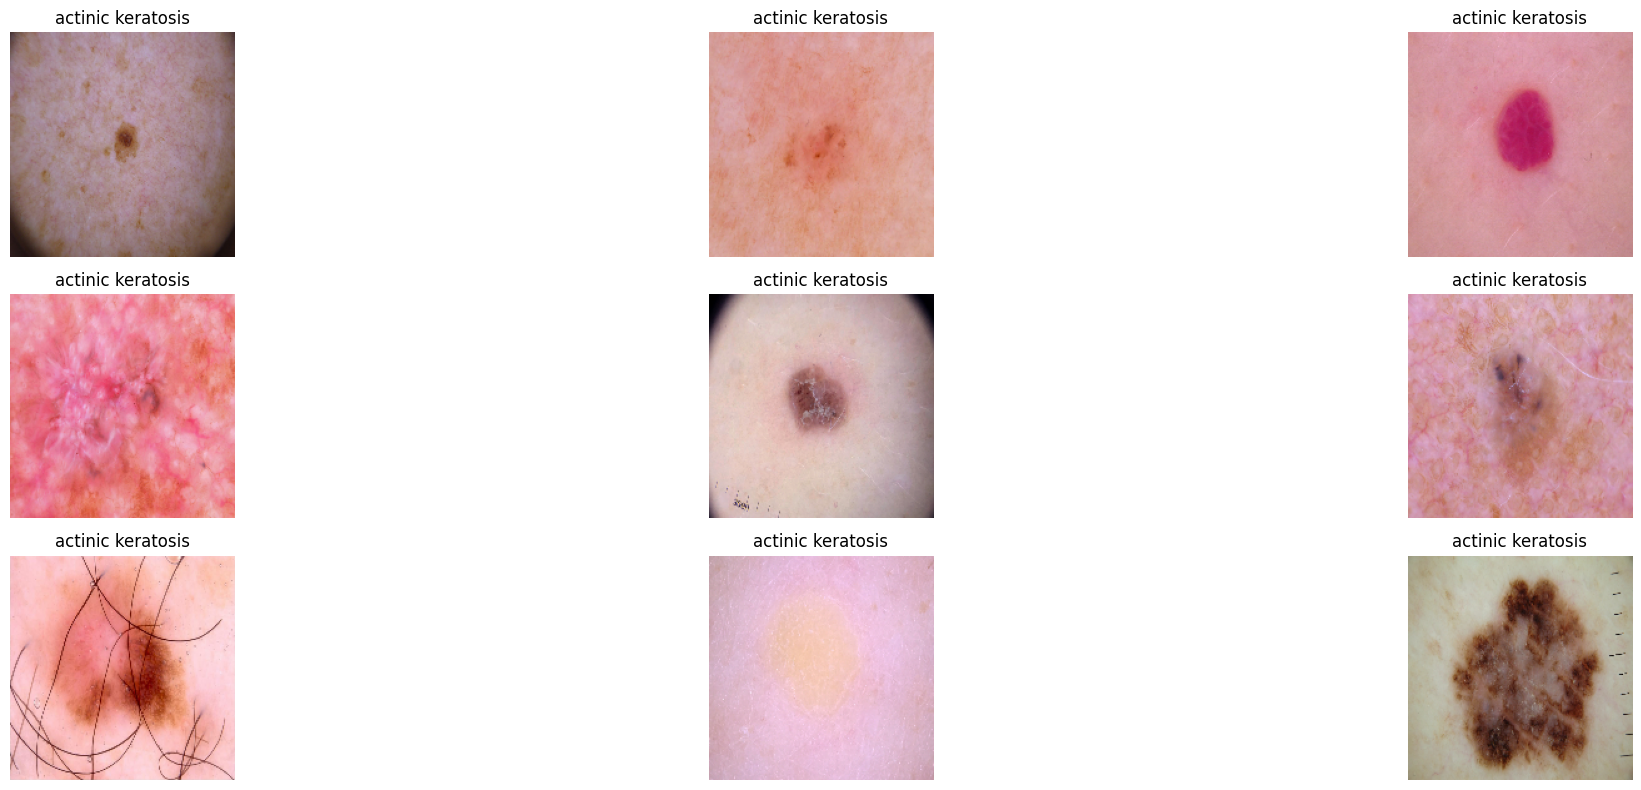

In [11]:

def visualize_dataset(dataset, class_names, num_images=9):
    plt.figure(figsize=(25,8))
    # Take one batch of data
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)  
            plt.imshow(images[i].numpy().astype("uint8"))  
            label_idx = np.argmax(labels[i].numpy())  
            plt.title(class_names[label_idx])  
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    
visualize_dataset(train_ds, class_names)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

There are 9 classes in the melanoma detection set.


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Utility for visualisaton

def modelVisualisation(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Model Building

Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [21]:
# Model configuration

model = Sequential()

# scaling
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#convo 64 layers
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(layers.MaxPool2D())

#convo 128
model.add(layers.Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

## Number of classes is 9
model.summary()





/Users/cramesh/Documents/upgrad/.venv/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,837,129 (121.45 MB)

 Trainable params: 31,837,129 (121.45 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [22]:
#using adam and sparse_categorical_crossentropy
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,837,129 (121.45 MB)

 Trainable params: 31,837,129 (121.45 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [23]:
#running on GPU 
epochs = 20
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

Epoch 1/20


2024-11-20 18:25:37.021965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.1914 - loss: 2.5523 - val_accuracy: 0.3065 - val_loss: 1.8785
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.3883 - loss: 1.6841 - val_accuracy: 0.4318 - val_loss: 1.6100
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.4793 - loss: 1.4877 - val_accuracy: 0.4072 - val_loss: 1.7082
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.5015 - loss: 1.3902 - val_accuracy: 0.4810 - val_loss: 1.4216
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5617 - loss: 1.2529 - val_accuracy: 0.5168 - val_loss: 1.4703
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5787 - loss: 1.1868 - val_accuracy: 0.5078 - val_loss: 1.4498
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6031 - loss: 1.0658 - val_accuracy: 0.5391 - val_loss: 1.4235
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6318 - loss: 1.0216 - val_accuracy: 0.5414 - val

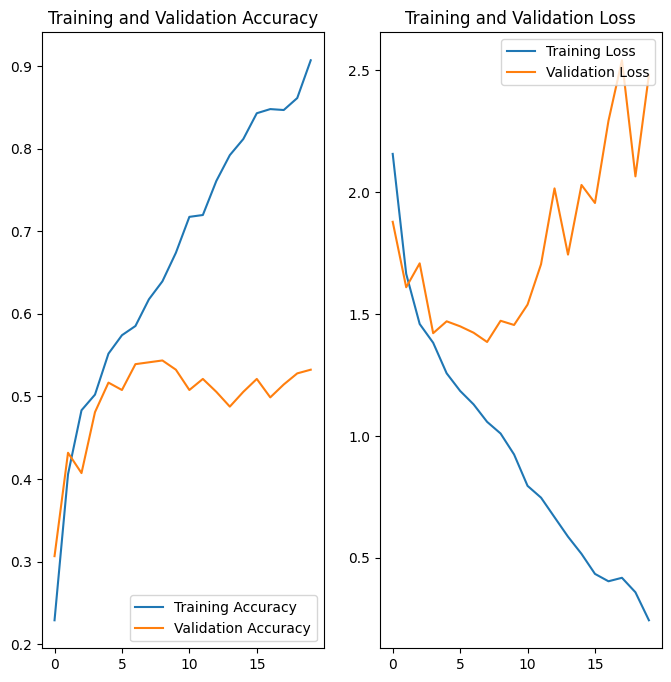

In [24]:
modelVisualisation(history,epochs)

### Visualizing training results

### Model Finding 

#### Accuracy: 
The training accuracy steadily improves, reaching 91.49% by the final epoch, while validation accuracy stagnates around 53%, indicating a gap in generalization.
### Loss:
Training loss consistently decreases, demonstrating effective learning, but validation loss increases after an initial decline, peaking at 2.54.
### Overfitting: 
The model overfits significantly as it achieves high training accuracy while validation accuracy remains low and validation loss worsens, suggesting insufficient generalization.

### Understanding How to deal with overfitting using agumentation

1. Understanding how a single image looks when passed through a augumentor

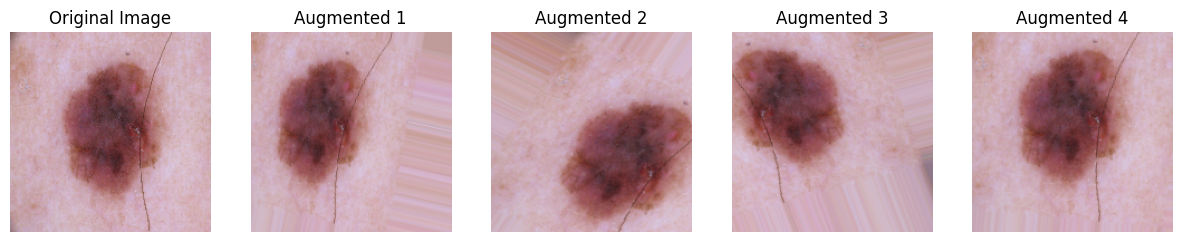

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load a sample image from the training dataset
img_path = './Train/melanoma/ISIC_0000139.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1, *img_array.shape))  # Add batch dimension


# Define the ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = datagen.flow(img_array, batch_size=1)

# Visualize the original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

# Display the original image
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Display 4 augmented images
for i in range(1, 5):
    aug_img = next(augmented_images)[0].astype('uint8')  # Corrected to use next()
    ax[i].imshow(aug_img)
    ax[i].set_title(f"Augmented {i}")
    ax[i].axis('off')

plt.show()




In [26]:
# Augumenting the data 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/Users/cramesh/Documents/upgrad/.venv/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Model configuration

model = Sequential()

# scaling
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# lets add the augmentation layer before the convolution layer
model.add(data_augmentation)

#convo 64 layers
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(layers.MaxPool2D())

#convo 128
model.add(layers.Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,837,129 (121.45 MB)

 Trainable params: 31,837,129 (121.45 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#using adam and sparse_categorical_crossentropy
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,837,129 (121.45 MB)

 Trainable params: 31,837,129 (121.45 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
epochs = 20
'''with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
       
    )'''
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
  6/169 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.7286 - loss: 0.7489

KeyboardInterrupt: 

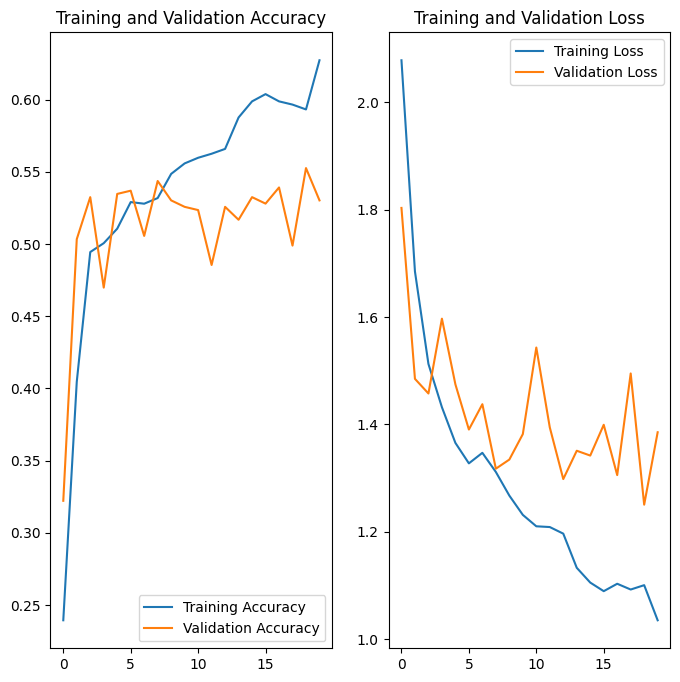

In [30]:
modelVisualisation(history,epochs)

There is a dip in the Accuracy of training , but there is also a dipin the validation loss .
Model 2, which includes data augmentation, performed better in terms of validation accuracy (up to 0.5526) compared to Model 1 (0.5324). Despite both models showing improvements in accuracy, Model 2 benefited from augmentation, preventing overfitting and leading to more robust generalization. Lets build using dropouts and BN

Rebuilding code of augumented data with BN and dropouts

In [32]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf

model = Sequential()

# scaling
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(data_augmentation)

model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

#using adam and sparse_categorical_crossentropy
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 180, 180, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 88, 88, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 88, 88, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 247808)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │   126,878,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,996,425 (484.45 MB)

 Trainable params: 126,995,913 (484.45 MB)

 Non-trainable params: 512 (2.00 KB)

In [62]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
'''with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
       
    )'''
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
 18/169 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - accuracy: 0.7018 - loss: 0.8034

KeyboardInterrupt: 

### Visualizing the results

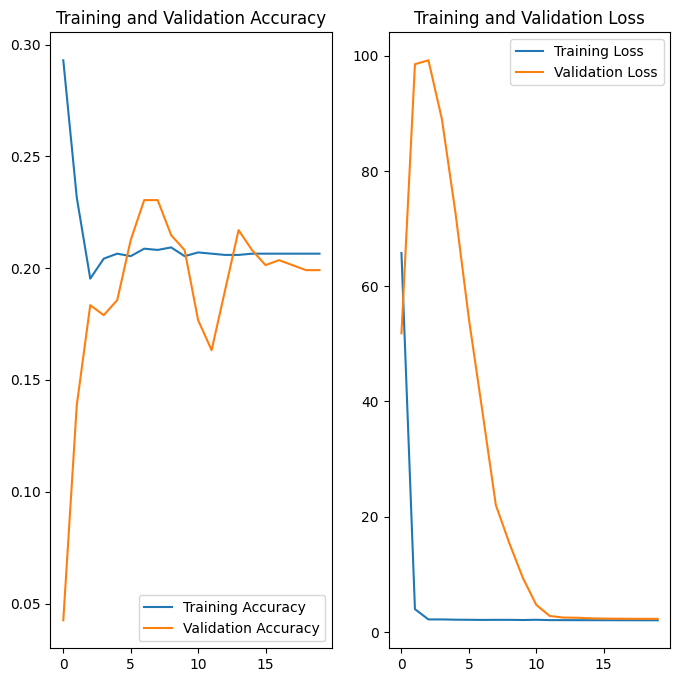

In [34]:
modelVisualisation(history,epochs)

While there is some minor improvement in terms of loss reduction, The reduction in overfitting compared to the first model is evident in the closer alignment of training and validation accuracies in the later epochs. 
But the accuracy seems to have dipped from the first model.
Class imbalance can help to improve further

### Class Distribution

In [35]:
#Lets analyse the class distribution
#Each class has different values of data which will be handled later as a part of class imbalance
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95



### Class 7 (seborrheic keratosis) has the fewest samples with only 77 images.

#### - Class 1 (pigmented benign keratosis): 462 images (most abundant).
#### - Class 0 (melanoma): 438 images.

In [36]:
path_to_training_dataset="./Train"
import Augmentor
for class_name in class_names:
    # Correctly join the paths using os.path.join
    class_path = os.path.join(path_to_training_dataset, class_name)
    
    # Check if the directory exists
    if not os.path.exists(class_path):
        print(f"Error: Directory {class_path} does not exist.")
    else:
        print(f"Directory {class_path} exists, starting pipeline...")
        # Create an Augmentor pipeline for the class
        p = Augmentor.Pipeline(class_path)
        
        # Add augmentations
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        
        # Generate 500 augmented images
        p.sample(500)

Directory ./Train/actinic keratosis exists, starting pipeline...
Initialised with 114 image(s) found.
Output directory set to ./Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x34794FCA0>: 100%|█| 500/500 [00:01<00:00, 374.1


Directory ./Train/basal cell carcinoma exists, starting pipeline...
Initialised with 376 image(s) found.
Output directory set to ./Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x387B46970>: 100%|█| 500/500 [00:04<00:00, 113.1


Directory ./Train/dermatofibroma exists, starting pipeline...
Initialised with 95 image(s) found.
Output directory set to ./Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3879D6040>: 100%|█| 500/500 [00:01<00:00, 418.9


Directory ./Train/melanoma exists, starting pipeline...
Initialised with 438 image(s) found.
Output directory set to ./Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x34BE612E0>: 100%|█| 500/500 [00:05<00:00, 86.1


Directory ./Train/nevus exists, starting pipeline...
Initialised with 357 image(s) found.
Output directory set to ./Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x358C7D7C0>: 100%|█| 500/500 [00:04<00:00, 113.2


Directory ./Train/pigmented benign keratosis exists, starting pipeline...
Initialised with 462 image(s) found.
Output directory set to ./Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x38761E940>: 100%|█| 500/500 [


Directory ./Train/seborrheic keratosis exists, starting pipeline...
Initialised with 77 image(s) found.
Output directory set to ./Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x34EFAB640>: 100%|█| 500/500 [00:02<00:00, 217.


Directory ./Train/squamous cell carcinoma exists, starting pipeline...
Initialised with 181 image(s) found.
Output directory set to ./Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x307C70130>: 100%|█| 500/500 [


Directory ./Train/vascular lesion exists, starting pipeline...
Initialised with 139 image(s) found.
Output directory set to ./Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x34D799E80>: 100%|█| 500/500 [00:01<00:00, 440.4


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
import glob
import os

# Define your base directory (example)
data_dir_train = './Train'  # Replace with your actual directory

# Use glob.glob() to find all .jpg files
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Print the result
#print(path_list_new)


In [41]:
import glob
import os

# Define your base directory (example)
data_dir_train = './Train'  # Replace with your actual directory

# Use glob.glob() to find all .jpg files in 'output' folder
jpg_files = glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))

# Extract the lesion directory names
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in jpg_files]

# Print the list of lesions
#print(lesion_list_new)


In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [44]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [46]:
data_dir_train="./Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(180, 180),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(180, 180),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model with BN , dropout and additional layer

In [53]:
model = Sequential()


# scaling
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(data_augmentation)

model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))
#using adam and sparse_categorical_crossentropy
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


/Users/cramesh/Documents/upgrad/.venv/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 180, 180, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 90, 90, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 45, 45, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,857 (1.95 MB)

 Trainable params: 508,937 (1.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [54]:


# Fit the model without early stopping
epochs = 30
'''with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
       
    )'''
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.2650 - loss: 2.4729 - val_accuracy: 0.0891 - val_loss: 2.9897
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.3295 - loss: 1.9315 - val_accuracy: 0.1314 - val_loss: 2.9732
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 268ms/step - accuracy: 0.3828 - loss: 1.7319 - val_accuracy: 0.1811 - val_loss: 2.3217
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.4050 - loss: 1.6275 - val_accuracy: 0.1886 - val_loss: 2.4878
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - accuracy: 0.4291 - loss: 1.5296 - val_accuracy: 0.1589 - val_loss: 2.7545
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - accuracy: 0.4577 - loss: 1.4640 - val_accuracy: 0.3073 - val_loss: 1.8192
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.4523 - loss: 1.4361 - val_accuracy: 0.3920 - val_loss: 1.7747
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step - accuracy: 0.4836 - loss: 1

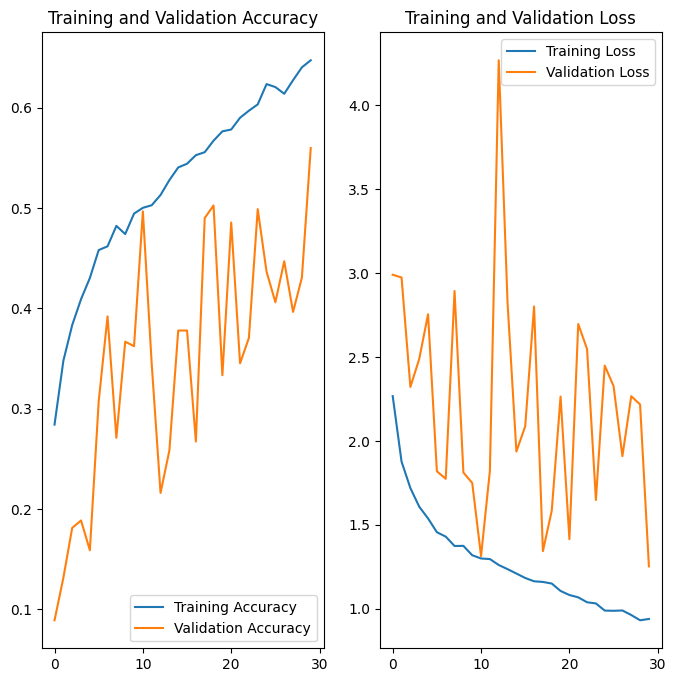

In [55]:
modelVisualisation(history,epochs)

### Final findings

Training vs Validation Accuracy: As the training accuracy increases linearly over time, the validation accuracy shows fluctuations but increases gradually during the training process. Although training accuracy improves steadily, validation accuracy lags behind, indicating some underfitting.

Training vs Validation Loss: As the training loss decreases with epochs, the validation loss also decreases, but not as significantly. The gap between the training loss and validation loss remains noticeable, showing the model still has room for improvement in generalizing.

Training and Validation Accuracy Gap: The gap between training accuracy and validation accuracy has decreased significantly from the previous model. By the end of training, the validation accuracy reached 55.98%, indicating some improvement but still a considerable difference from the training performance, suggesting further optimization is required to bridge the gap.

### There is a significant reduction in overfitting also a good increase in accuracy compared to model with augumentation alone 

#### Trying out early stopping

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

#using adam and sparse_categorical_crossentropy
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=0.9, 
    restore_best_weights=True, 
    verbose=1
)

# Fit the model with early stopping
epochs = 30
'''with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping]
    )'''
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/30
  4/169 ━━━━━━━━━━━━━━━━━━━━ 48s 295ms/step - accuracy: 0.5885 - loss: 1.0932

KeyboardInterrupt: 

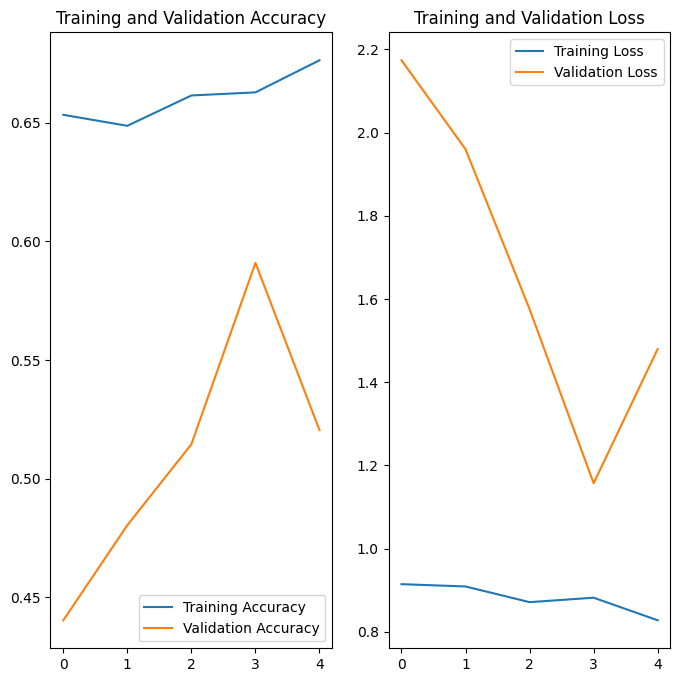

In [59]:
modelVisualisation(history,5)

Early stopping is good when we have a narrow down on teh val_loss . Can be more slower in terms of patience level and try more scenario